# Attention mechanisms

## Dataset

We will use a dataset from <https://github.com/Charlie9/enron_intent_dataset_verified?tab=readme-ov-file>. This dataset consists of sentences from emails sent between employees of the Enron corporation. Each sentence has been manually labeled regarding whether it contains a request or does not contain a request. We will train an attention model to classify sentences as "request" or "no request" sentences.

In [1]:
def read_intent_file(file_path: str) -> list[str]:
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

# Read positive and negative intent files
pos_intent_path = "data/Enron/intent_pos"
neg_intent_path = "data/Enron/intent_neg"

pos_intent_sentences = read_intent_file(pos_intent_path)
neg_intent_sentences = read_intent_file(neg_intent_path)

Take a look at some of these sentences. Does the dataset look as you would expect?

In [2]:
for i in range(5):
    # print out some sentences and remove the ...
    pass

## Tokenization

Now that we have the sentences, we need to parse them into tokens that can be fed to the model. Tokenization is a surprisingly complicated task which is highly language-dependent.

(It is not as simple as identifying words; often parts of words are themselves individual tokens. The past-tense marker `-ed` must be separated from the verb `trained`, for example, to create two tokens: `train` and `ed`. German, then, requires a different algorithm --- the word `trainiert` clearly has the token `t` at the end, but then should the tokens be `trainieren` and `t`? Or `trainier` and `t`?).

Luckily, we are physicists rather than linguists, and some very clever people have done the work already. We can parse the sentences using a pre-written tokenizer from PyTorch.

NB: You may get an error like

```txt
A module that was compiled using NumPy 1.x cannot be run in NumPy 2.2.5 as it may crash.
```

You can safely ignore this warning and just re-run the cell. It should not affect the rest of the tutorial.

In [3]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('basic_english')
tokens = tokenizer("Please send me the report by EOD.")
tokens

['please', 'send', 'me', 'the', 'report', 'by', 'eod', '.']

Tokenize some sentences of your choosing and see what happens. Does it work as you expect, or are there any surprises? What if you try to tokenize a non-English sentence?

In [4]:
# Tokenize some sentences

Now that we can tokenize individual sentences, we need to build up a vocabulary of tokens that appear in our training data. We will also add two new tokens to the vocabulary --- a token `<unk>` representing an unknown input, and a token `<pad>` for whitespace padding.

In [5]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    for txt in data_iter:
        yield tokenizer(txt)

all_sentences = pos_intent_sentences + neg_intent_sentences

vocab = build_vocab_from_iterator(yield_tokens(all_sentences), specials=["<unk>", "<pad>"])

# We set the default token to be <unk>
vocab.set_default_index(vocab['<unk>'])

Take a look at a few entries of the `vocab` object. What sort of object is it? What does it map words onto?

In [6]:
# Look at some vocab entries

# print(vocab['the'])

## Model training

Now let's train an attention-based model to classify sentences as requests or not. We will train an extremely simple model with a single attention head, just to show you how it all works.

First, we need to load the data into a PyTorch `DataLoader` that can be passed to the model. This is necessary for easy parallelization of the training (though it is not critical for us in this application).

We have hidden some technical details in the `data_management.py` file. Feel free to look at the implementation in there if you are curious.

In [7]:
import torch

from data_management import EnronRequestDataset, collate_fn
from torch.utils.data import DataLoader

# Gather sentences and assign labels
sentences = pos_intent_sentences + neg_intent_sentences
labels = [1] * len(pos_intent_sentences) + [0] * len(neg_intent_sentences)

# Wrap the sentences in a DataLoader object
dataset = EnronRequestDataset(sentences, labels, vocab, tokenizer)
loader  = DataLoader(dataset,
                     batch_size=32,
                     shuffle=True,
                     collate_fn=lambda batch: collate_fn(batch, vocab),
                     num_workers=0,
                     pin_memory=True)


Now we can actually train the model! In order to best understand what is happening, we will use a very simple attention mechanism attached to a multilayer perceptron. The implementation has been hidden in the file `attention_model.py` --- feel free to look in there if you'd like! It's not as scary as you might think.

For now, we will focus on trying to understand what the model is doing. First, we will load the model.

In [8]:
import attention_model

import torch.nn as nn

model = attention_model.RequestClassifier(len(vocab), num_layers=1)

What does the model look like?

In [9]:
model

RequestClassifier(
  (embed): Embedding(6983, 128)
  (layers): ModuleList(
    (0): SimpleEncoderLayer(
      (self_attn): SimpleAttention(
        (q): Linear(in_features=128, out_features=128, bias=True)
        (k): Linear(in_features=128, out_features=128, bias=True)
        (v): Linear(in_features=128, out_features=128, bias=True)
        (out): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)

Now let's see how the untrained model performs on the dataset. We can define a simple function to compute the true and false positive rates.

In [10]:
# Compute true positives, false positives, true negatives, and false negatives
def compute_metrics(preds, labels):
    tp = ((preds == 1) & (labels == 1)).sum().item()
    fp = ((preds == 1) & (labels == 0)).sum().item()
    tn = ((preds == 0) & (labels == 0)).sum().item()
    fn = ((preds == 0) & (labels == 1)).sum().item()
    return tp, fp, tn, fn

# Evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for src, labels, pad_mask in data_loader:
            logits = model(src, src_key_padding_mask=pad_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    tp, fp, tn, fn = compute_metrics(all_preds, all_labels)
    print(f"True positive rate: {tp / (tp + fn) * 100:.2f}%")
    print(f"False positive rate: {fp / (fp + tn) * 100:.2f}%")
    print("")
    print(f"True negative rate: {tn / (tn + fp) * 100:.2f}%")
    print(f"False negative rate: {fn / (fn + tp) * 100:.2f}%")

evaluate_model(model, loader)

True positive rate: 47.04%
False positive rate: 37.49%

True negative rate: 62.51%
False negative rate: 52.96%


You should have found that the true and false positive (and true and false negative) are quite bad. This is expected for the untrained model --- it is just randomly guessing.

Now let's perform the training. We can train the model over a small number of epochs using a simple binary cross-entropy loss function. Play around with the learning rate and number of epochs --- what do you find in terms of performance?

In [11]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 20

for epoch in range(epochs):
    loss = torch.tensor(0.0)
    for src, labels, pad_mask in loader:
        logits = model(src, src_key_padding_mask=pad_mask)
        loss   = loss_fn(logits, labels)

        if torch.isnan(logits).any():
            print("🛑 NaN in logits!"); break

        loss.backward()
        opt.step(); opt.zero_grad()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/20, Loss: 0.1985
Epoch 2/20, Loss: 0.5186
Epoch 3/20, Loss: 0.8062
Epoch 4/20, Loss: 0.1147
Epoch 5/20, Loss: 0.0108
Epoch 6/20, Loss: 0.0386
Epoch 7/20, Loss: 0.0006
Epoch 8/20, Loss: 0.0021
Epoch 9/20, Loss: 0.0590
Epoch 10/20, Loss: 0.0058
Epoch 11/20, Loss: 0.0000
Epoch 12/20, Loss: 0.0003
Epoch 13/20, Loss: 0.0002
Epoch 14/20, Loss: 0.0003
Epoch 15/20, Loss: 0.0002
Epoch 16/20, Loss: 0.0020
Epoch 17/20, Loss: 0.0001
Epoch 18/20, Loss: 0.0000
Epoch 19/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000


We have trained a very simple model as a proof-of-concept, but think about what might be missing here, using what you have learned from the other tutorials in the workshop. Would you want to deploy this model in the real world? How could we make it better?

## Evaluation

Now that the model is trained, we can evaluate its performance. First, we should compute the true positive and false positive rates.

In [12]:
evaluate_model(model, loader)


True positive rate: 100.00%
False positive rate: 0.00%

True negative rate: 100.00%
False negative rate: 0.00%


You probably found very good performance (unless something went wrong with the training). In fact, the true positive and true negative rates might be 100%. This is indicative of some possible overfitting in the model --- how could we avoid overfitting for future training?

Now that we have the trained model, we can play around with it a bit. Let's write a function to evaluate a single sentence.

In [13]:
# Evaluate single sentence
import torch
import torch.nn.functional as F

def predict_sentence(model, sentence, vocab, tokenizer) -> tuple[int, list[float]]:
    model.eval()
    with torch.no_grad():
        # Tokenize and map to vocabulary
        tokens = tokenizer(sentence)
        ids    = torch.tensor(vocab(tokens), dtype=torch.long).unsqueeze(0)

        # Build padding mask (necessary to pad empty characters)
        pad_idx = vocab['<pad>']
        mask    = ids != pad_idx

        # Run the transformer
        logits = model(ids, src_key_padding_mask=~mask)
        probs  = F.softmax(logits, dim=-1)

        # Return the class with the highest probability (0 or 1)
        pred   = probs.argmax(dim=-1).item()

    # Convert prediction to int
    pred = int(pred)

    return pred, probs.squeeze().tolist()

def print_prediction_for_sentence(sentence, whitespace=True):
    pred, probs = predict_sentence(model, sentence, vocab, tokenizer)

    label_map = {0: "no_request", 1: "request"}
    print(f"→ {sentence!r}")
    print(f"Prediction: {label_map[pred]} (P(request)={probs[1]:.4f})")

    if whitespace:
        print()

test_sentences = [
    "Please send me the report today by the end of the day.",
    "I need the report as soon as possible.",
    "Can you send me the report?",
    "The weather is nice today.",
    "Knut is teaching a lecture on transformers.",
    "Student, please evaluate the model performance."
]

for sentence in test_sentences:
    print_prediction_for_sentence(sentence)


→ 'Please send me the report today by the end of the day.'
Prediction: request (P(request)=1.0000)

→ 'I need the report as soon as possible.'
Prediction: request (P(request)=1.0000)

→ 'Can you send me the report?'
Prediction: request (P(request)=1.0000)

→ 'The weather is nice today.'
Prediction: no_request (P(request)=0.0000)

→ 'Knut is teaching a lecture on transformers.'
Prediction: no_request (P(request)=0.0000)

→ 'Student, please evaluate the model performance.'
Prediction: no_request (P(request)=0.0001)



This is looking pretty good! Try playing around now with your own sentences.

In [14]:
# Write a request that you might find in a business email (so it uses words that might be in the vocab)
sentence = "Write a request here."
print_prediction_for_sentence(sentence)

# Write a non-request that you might find in a business email
sentence = "Write a non-request here."
print_prediction_for_sentence(sentence)

# Write a request with some words that you think might not be in the vocab
sentence = "Write a request with non-vocab words here."
print_prediction_for_sentence(sentence)

# Write a request in another language (e.g., German)
sentence = "Schreiben Sie eine Anfrage in einer anderen Sprache hier."
print_prediction_for_sentence(sentence)

# Write any sentence of your choosing
sentence = "Your sentence here."
print_prediction_for_sentence(sentence)

→ 'Write a request here.'
Prediction: no_request (P(request)=0.0000)

→ 'Write a non-request here.'
Prediction: no_request (P(request)=0.0000)

→ 'Write a request with non-vocab words here.'
Prediction: no_request (P(request)=0.0000)

→ 'Schreiben Sie eine Anfrage in einer anderen Sprache hier.'
Prediction: no_request (P(request)=0.0000)

→ 'Your sentence here.'
Prediction: no_request (P(request)=0.0000)



What do you notice about the model behavior? Do certain words seem to cause the model to predict a sentence as being more request-like? Do certain requests consistently fail? Can you figure out how to modify an incorrectly-classified request in order to make it classify correctly?

## Visualization

Let's try to visualize what the attention mechanism is doing. For the following sections, if you have changed the topology of your classifier model, make sure that there is only one attention layer.

Let's use an example sentence that evaluates as a prediction.

In [15]:
visualization_sentence = "Please send me this email today."
print_prediction_for_sentence(visualization_sentence)

→ 'Please send me this email today.'
Prediction: request (P(request)=1.0000)



The attention model has been written in such a way that we can extract the attention matrix from the last attention layer of the network. Let's grab it now.

In [16]:
import numpy as np

def get_attention_matrix(model, sentence, vocab, tokenizer):
    tokens = tokenizer(sentence)
    ids = torch.tensor(vocab(tokens), dtype=torch.long).unsqueeze(0)
    pad_mask = ids == vocab['<pad>']

    model.eval()
    with torch.no_grad():
        _, attention_raw = model(
            ids, src_key_padding_mask=pad_mask, return_attn=True
        )
        attention = np.asarray(attention_raw[0].detach().cpu().tolist())

    return attention

attention = get_attention_matrix(model, visualization_sentence, vocab, tokenizer)
print("Attention matrix:")
print(attention)

Attention matrix:
[[2.41790345e-04 4.47287083e-01 3.96403437e-03 1.79027729e-02
  3.86034437e-02 4.83132243e-01 8.86869524e-03]
 [1.07198621e-05 8.87959480e-01 3.49904001e-02 5.82900317e-03
  3.28337820e-03 3.82676236e-02 2.96594407e-02]
 [1.18826407e-04 8.60153317e-01 2.72390516e-05 2.02885550e-03
  6.38713464e-02 4.65960540e-02 2.72043254e-02]
 [4.22835816e-04 7.74847627e-01 2.07166802e-02 7.00769899e-03
  2.29659956e-02 1.29273400e-01 4.47657518e-02]
 [1.30026443e-02 3.15059945e-02 1.06853999e-01 2.46869728e-01
  5.34730777e-03 2.47483402e-02 5.71672022e-01]
 [2.88243890e-01 1.72726363e-02 1.89236343e-01 3.73061821e-02
  4.38184261e-01 2.73180287e-02 2.43872660e-03]
 [8.44541669e-01 1.30541826e-04 2.22915616e-02 2.00614007e-03
  1.25563800e-01 5.46460319e-03 1.73532931e-06]]


We can interpret the entry in `[row, column] = [i, j]` in the attention matrix as the weight of a query `j` to be used in a linear update of key `i`. For a simple network with a single attention mechanism, this tells you which query words are important to update the meaning of each key word. Thus, if we plot the attention matrix, we can see which words in the sentence influence the meanings of other words (according to the model).

We have written a very simple visualization of the sentence, which we can observe below.

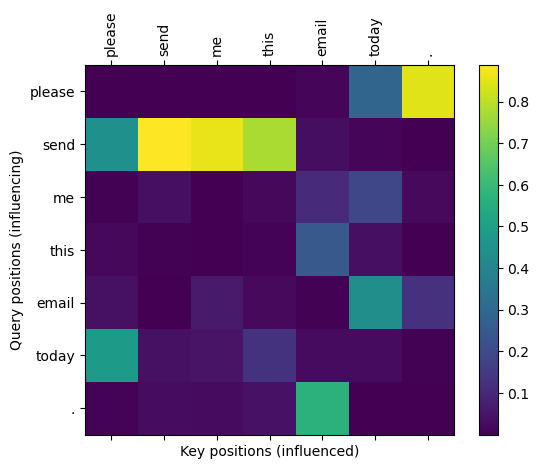

In [17]:
import visualization

tokens = tokenizer(visualization_sentence)
visualization.plot_attention(tokens, attention)


You might find, for example, that the word `please` is influencing the meaning of the word `email`, while it is influence by the words `send` and `this`.

Let's look at the numerical importance of the top `(key, query)` pairs.

In [18]:
# Find top (key, query) pairs from attention matrix
def find_top_k_pairs(attention, sentence, tokenizer, k=5):
    tokens = tokenizer(sentence)
    top_k_indices = np.unravel_index(np.argsort(attention.ravel())[-k:], attention.shape)
    top_k_pairs = [(tokens[i], tokens[j]) for i, j in zip(*top_k_indices)]
    attention_values = [attention[i, j] for i, j in zip(*top_k_indices)]

    top_k_pairs = sorted(zip(top_k_pairs, attention_values), key=lambda x: x[1], reverse=True)
    return top_k_pairs

def print_top_k_pairs(attention, sentence, tokenizer, k=5):
    top_k_pairs = find_top_k_pairs(attention, sentence, tokenizer, k=k)
    print("Top (query, key) pairs")
    print("query -> key : attention")
    print("------------------------")
    print("")
    for (key, query), pair_attn in top_k_pairs:
        print(f"{query} → {key} : {pair_attn:.4f}")

print_top_k_pairs(attention, visualization_sentence, tokenizer, k=8)

Top (query, key) pairs
query -> key : attention
------------------------

send → send : 0.8880
send → me : 0.8602
please → . : 0.8445
send → this : 0.7748
. → email : 0.5717
today → please : 0.4831
send → please : 0.4473
email → today : 0.4382


Do these results make sense to you?

We can also sum over the keys to see which queries are the most important as influencing words.

In [19]:
visualization.display_sentence_with_alpha(visualization_sentence, tokenizer, attention)

Let's package everything into a single function for easy visualization.

→ 'Please send me this email today.'
Prediction: request (P(request)=1.0000)


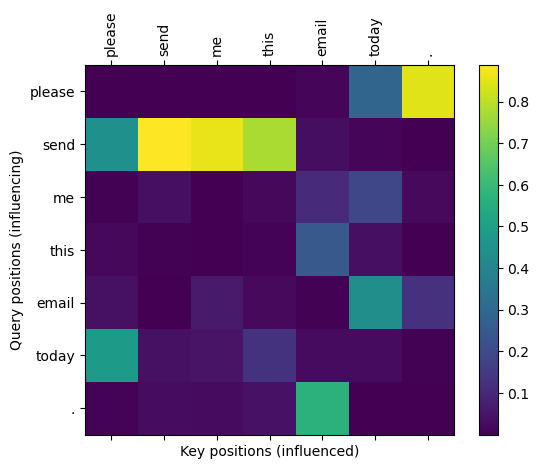

Top (query, key) pairs
query -> key : attention
------------------------

send → send : 0.8880
send → me : 0.8602
please → . : 0.8445
send → this : 0.7748
. → email : 0.5717
today → please : 0.4831
send → please : 0.4473
email → today : 0.4382


In [20]:
def run_visualization(model, sentence, vocab, tokenizer):
    print_prediction_for_sentence(sentence, whitespace=False)

    attention = get_attention_matrix(model, sentence, vocab, tokenizer)

    visualization.display_sentence_with_alpha(sentence, tokenizer, attention)

    tokens = tokenizer(sentence)
    visualization.plot_attention(tokens, attention)

    print_top_k_pairs(attention, sentence, tokenizer, k=8)

run_visualization(model, visualization_sentence, vocab, tokenizer)

Now it's your turn! Play around with a few sentences. What do you notice? Is the model focusing on what you expect?

→ 'Your sentence here.'
Prediction: no_request (P(request)=0.0000)


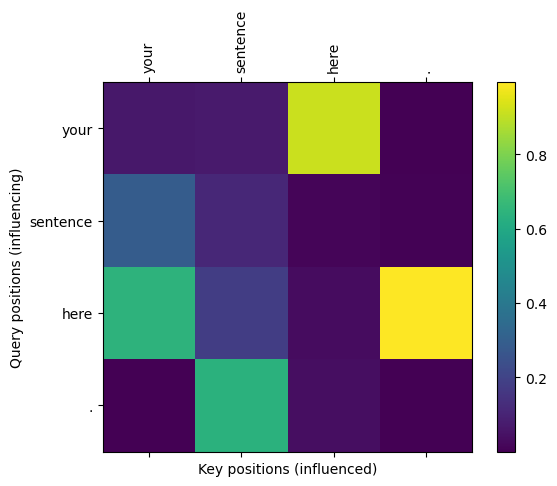

Top (query, key) pairs
query -> key : attention
------------------------

here → . : 0.9950
your → here : 0.9163
here → your : 0.6430
. → sentence : 0.6345
sentence → your : 0.2911
here → sentence : 0.1820
sentence → sentence : 0.1115
your → sentence : 0.0721


In [21]:
test_sentence = "Your sentence here."

run_visualization(model, test_sentence, vocab, tokenizer)

## Extensions

If you have gotten to this point and are bored, here are some suggested extensions for you.

### Play around with the model code

Take a look at the implementation of the model. Read the functions and see if they make sense to you. Feel free to edit the model topology and see what happens!

### Add additional layers to the model

The model is constructed to allow for the parameter `num_layers`. Each layer is a combination of an attention mechanism and a multilayer perceptron network. What happens if you increase the number of layers from 1 to a higher number? How does the performance of the model change? Does the visualization still make as much sense?

Note that the visualization will always draw from the *last* attention layer. After the first attention layer, the token vectors have already been updated, so it is much more difficult to interpret the meaning of subsequent attention matrices.

### Augment the training sample

Maybe there are some words that are not present in the vocabulary yet, but are relevant to you. These words will not be interpretable by the model, since it has never seen them. The solution is to get more training data!

For now, the easiest way to generate the training data is to do it by hand. Try adding some request and non-request examples to the training dataset, and make sure that they use words that don't exist in the dataset yet (physics-related words are good candidates here). See how the old model treats sentences that use these words (question: how would these words be treated before they are present in the vocabulary?), then train a new model with an updated vocabulary, and look at how the performance changes.

### [Hard] Train a model for a new task

You can try to train a model for a new task. Many text datasets can be found online. The dataset <https://www.ims.uni-stuttgart.de/forschung/ressourcen/korpora/deisear/> for example contains many examples of English and German sentences, classified by expressed emotion. You could download this dataset, perform the necessary preprocessing, and train a model to classify emotions.

A few things to note:

- The dataset has the emotion removed from each sentence. It might be helpful to preprocess the sentences to restore the emotion, in order to train over complete sentences.
- There are more than 2 emotions in the dataset. You could train in one of two ways:
  - Classify emotions as positive or negative, and then train a classifier to determine whether a given sentence is positive or negative. This will allow you to use the model that has already been written.
  - Classify the emotion itself. This will require you to encode the emotions under a "one-hot encoding," where the sentence labels are vectors of length `n_emotions`. Then each emotion is assigned an entry in the vector, so that a label for a given emotion would have a `1` in that place and a `0` elsewhere. For example, imagine you have 3 emotions: `happy`, `sad`, and `calm`. Then a label for `happy` could be `[1, 0, 0]`, a label for `sad` could be `[0, 1, 0]`, etc. The model will need to be updated to output vectors into an `n_emotions`-dimensional space.
- If you use the German-language sentences, you will need a German-language tokenizer. The conda environment specified in `environment.yml` includes `spaCy`, which is a tokenizer with a list of languages available here: <https://spacy.io/usage/models#section-languages>

To load a new tokenizer, you can download the dictionary with, e.g.,

In [1]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 11.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


and then load the tokenizer with

In [6]:
tokenizer_de = get_tokenizer('spacy', language='de_core_news_sm')